Recode of my Springboard capstone, attempting and comparing different regression techniques.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
%matplotlib inline

In [2]:
df=pd.read_csv("../dc-residential-properties/DC2R.csv",index_col=0)

In [3]:
#Some Basic EDA:
print(df.describe())

              BATHRM      NUM_UNITS          ROOMS          BEDRM  \
count  106696.000000  106696.000000  106696.000000  106696.000000   
mean        2.033103       1.198039       7.382329       3.368514   
std         1.062017       0.596924       2.295587       1.100649   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       6.000000       3.000000   
50%         2.000000       1.000000       7.000000       3.000000   
75%         3.000000       1.000000       8.000000       4.000000   
max        14.000000       6.000000      48.000000      24.000000   

                 AYB        STORIES         PRICE            GBA  \
count  106455.000000  106652.000000  5.790000e+04  106696.000000   
mean     1933.888413       2.091793  5.799119e+05    1714.539889   
std        28.307306       2.933323  6.076454e+05     880.677860   
min      1754.000000       0.000000  1.000000e+00       0.000000   
25%      1914.000000       2.000000  2

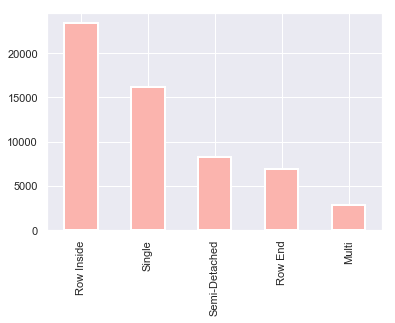

In [6]:
#Cleaning out some building types that are incredibly rare.
df['STRUCT']=df['STRUCT'].astype(str)
df= df[~df.STRUCT.str.contains("nan")]
df= df[~df.STRUCT.str.contains("Default")]
df= df[~df.STRUCT.str.contains("Vacant Land")]
df= df[~df.STRUCT.str.contains("Town End")]
df= df[~df.STRUCT.str.contains("Town Inside")]


#Visualize our distribution of building structures:
df['STRUCT'].value_counts().plot(kind='bar',linewidth=2,colormap='Pastel1') 

In [9]:
#Preprocessing data, creating new column to show price per square foot.
import sklearn.preprocessing as prep

df=df.dropna()
df['PPSQ']=df['PRICE']/df['GBA']

X=pd.get_dummies(df[['AYB','FIREPLACES','STORIES','NUM_UNITS']])
y= df['PPSQ']

#Seeing what our data looks like now:
print(df.shape)
print(df.head())

(57507, 17)
   BATHRM           HEAT AC  NUM_UNITS  ROOMS  BEDRM     AYB  STORIES  \
0       4      Warm Cool  Y          2      8      4  1910.0      3.0   
2       3  Hot Water Rad  Y          2      9      5  1910.0      3.0   
3       3  Hot Water Rad  Y          2      8      5  1900.0      3.0   
5       3  Hot Water Rad  Y          1     10      5  1913.0      4.0   
7       3  Hot Water Rad  Y          2      8      4  1906.0      3.0   

       PRICE   GBA      STRUCT        ROOF  KITCHENS  FIREPLACES  LANDAREA  \
0  1095000.0  2522  Row Inside  Metal- Sms       2.0           5      1680   
2  2100000.0  2522  Row Inside    Built Up       2.0           4      1680   
3  1602000.0  2484  Row Inside    Built Up       2.0           3      1680   
5  1950000.0  5344  Row Inside    Built Up       1.0           4      2196   
7  1050000.0  2401  Row Inside  Metal- Sms       2.0           1      1627   

  ASSESSMENT_NBHD        PPSQ  
0      Old City 2  434.179223  
2      Old City 

## Predicting Price per Square Foot

In [11]:
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

dtr=DTR(random_state=0)
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.3)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
mse_dtr = MSE(y_test, y_pred)

# What is the RMSE of our model?
rmse_dtr = mse_dtr**(1/2)
print("Test set RMSE of dtr: {:.2f}".format(rmse_dtr))
print(df['PPSQ'].mean())

Test set RMSE of dtr: 208.05
327.9176448356829


In [7]:
#What were the important features of our regressor?
#IMPORTANT: one-hot encoding creates dummy variables for categorical variables.
#It's therefore not amenable to ranking feature importances. It's still useful to view some, though.
feature_importances = pd.DataFrame(dtr.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)
#It looks like neighborhood has a big impact on price.

            importance
AYB           0.477996
FIREPLACES    0.299926
STORIES       0.143689
NUM_UNITS     0.078389


Now, let's measure the effect of different features using logistic regression.

In [36]:
import statsmodels.api as sm
import pylab as pl
heat=pd.get_dummies(df['HEAT'])
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)
stories=pd.get_dummies(df['STORIES'])
logit = sm.Logit(df['PRICE'],heat)

# fit the model
result = logit.fit()

ValueError: endog must be in the unit interval.

In [37]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()

X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.3, random_state=1)
lreg.fit(X_train,y_train)
y_pred = lreg.predict(X_test)
mse_dtr = MSE(y_test, y_pred)

# What is the RMSE of our model?
rmse_dtr = mse_dtr**(1/2)
print("Test set RMSE of dtr: {:.2f}".format(rmse_dtr))
print(df['PPSQ'].mean())

Test set RMSE of dtr: 236.65
327.9176448356829


Whether using linear regression or Decision Trees, we have some nasty large RMSEs. To get a better predictor of price, let's try the Ridge and Lasso techniques.

linear regression train score: 0.1165482996766597
linear regression test score: 0.07958425044746043
ridge regression train score low alpha: 0.11654829967664926
ridge regression test score low alpha: 0.07958425010739478
ridge regression train score high alpha: 0.11654725647939257
ridge regression test score high alpha: 0.07958002937309672


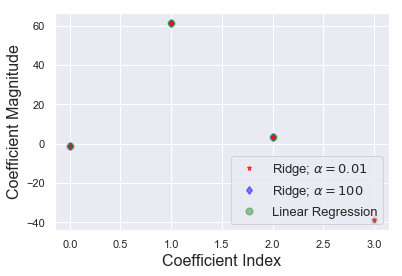

Test set RMSE of linear regression: 255.91
327.9176448356829


In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)

rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
ypredlow=rr.predict(X_test)
rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(X_train, y_train)

train_score=lr.score(X_train, y_train)
test_score=lr.score(X_test, y_test)

Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)

Ridge_train_score100 = rr100.score(X_train,y_train)
Ridge_test_score100 = rr100.score(X_test, y_test)

print("linear regression train score:", train_score)
print("linear regression test score:", test_score)
print("ridge regression train score low alpha:", Ridge_train_score)
print("ridge regression test score low alpha:", Ridge_test_score)
print("ridge regression train score high alpha:", Ridge_train_score100)
print("ridge regression test score high alpha:", Ridge_test_score100)

plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers

plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency

plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

mse_dtr = MSE(y_test, y_pred)

# What is the RMSE of our model?
rmse_dtr = mse_dtr**(1/2)
print("Test set RMSE of linear regression: {:.2f}".format(rmse_dtr))
print(df['PPSQ'].mean())

training score: 0.11646859280806376
test score:  0.08024078842711835
number of features used:  4
training score for alpha=0.01: 0.11654829959695301
test score for alpha =0.01:  0.07958498618727672
number of features used: for alpha =0.01: 4
training score for alpha=0.0001: 0.11654829967586244
test score for alpha =0.0001:  0.07958432402551907
number of features used: for alpha =0.0001: 4
LR training score: 0.1165482996766597
LR test score:  0.07958425044746043


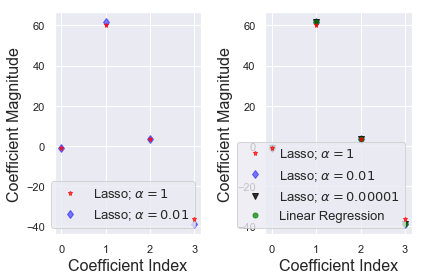

Test set RMSE of dtr: 255.91
327.9176448356829


In [38]:
import math 

# difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_breast_cancer

X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=31)

lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

print("training score:", train_score) 
print("test score: ", test_score)
print("number of features used: ", coeff_used)

lasso001 = Lasso(alpha=0.001, max_iter=10e5)
lasso001.fit(X_train,y_train)

train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print("training score for alpha=0.01:", train_score001) 
print("test score for alpha =0.01: ", test_score001)
print("number of features used: for alpha =0.01:", coeff_used001)

lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)

train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

print("training score for alpha=0.0001:", train_score00001)
print("test score for alpha =0.0001: ", test_score00001)
print("number of features used: for alpha =0.0001:", coeff_used00001)

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)

print("LR training score:", lr_train_score)
print("LR test score: ", lr_test_score)

plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)

plt.subplot(1,2,2)

plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()

mse_dtr = MSE(y_test, y_pred)

# What is the RMSE of our model?
rmse_dtr = mse_dtr**(1/2)
print("Test set RMSE of dtr: {:.2f}".format(rmse_dtr))
print(df['PPSQ'].mean())